<a href="https://colab.research.google.com/github/hvauchar/SAMHAR-COVID19-Hackathon/blob/master/Simple_Vanilla_CNN_COVID19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Solution
!pwd
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/covid19/Solution
/content/gdrive/My Drive/covid19/Solution
Augmentation-Kaggle-CNN-COVID19.ipynb	   Simple-Vanilla-CNN-COVID19.ipynb
chest_xray				   Submission.ppt
DataAnalysis.ipynb			   test_acc-95.h5
Kaggle-CNN-COVID19-TransferLearning.ipynb


**Import all the necessary packages required and Make sure your on Tensorflow version 2.2.0-rc3** 

In [0]:
import tensorflow as tf
print(tf.__version__)
import datetime
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, SeparableConv2D, BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
import seaborn as sns
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections

2.2.0-rc3


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Download the kaggle dataset from this [link](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) and put the zip file in folder with name train and then unzip the dataset 

In [0]:
path_train = 'chest_xray/train/'
path_test = 'chest_xray/test/'
path_val = 'chest_xray/val/'

Load the dataset and preprocess images by 

1.   resizing it (250x250) Note that we are resizing it to small size just because of limited computational resources ideally the size should not be the same.
2.   Normalize Images by scaling pixels between 0 - 1 by dividing image by 255.
3. Append the Lables and Images to a list and shuffel it make sure we wrote the logic of **Under-Sampling** the data with in the function.
4. Reshape Images and lables.
5. Create train and test set and return it.




In [0]:
CATEGORIES = ['NORMAL','PNEUMONIA']
IMG_SIZE=250
def create_training_data(dirlist):
  training_data=[]
  c = 0
  for DATADIR in dirlist:
    category0 = CATEGORIES[0]
    path = os.path.join(DATADIR,category0)
    class_num = CATEGORIES.index(category0)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))/255.0
        training_data.append([new_array,class_num])
        c += 1
      except Exception as e:
        print(e)
    category1 = CATEGORIES[1]
    path = os.path.join(DATADIR,category1)
    class_num = CATEGORIES.index(category1)
    for img in os.listdir(path):
      if(c>=0):
        try:
          img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
          new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))/255.0
          training_data.append([new_array,class_num])
          c -= 1
        except Exception as e:
          print(e)
      else:
        break
  random.shuffle(training_data)
  X=[]
  Y=[]
  for fetures, lable in training_data:
    X.append(fetures)
    Y.append(lable)
  X=np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)
  print(collections.Counter(Y))
  return(train_test_split(X,np.array(Y).reshape(-1,1),test_size=0.3, random_state=42))
dirlist = [path_val,path_test,path_train]

In [0]:
X_train, X_test, y_train, y_test = create_training_data(dirlist)

In [0]:
for i in (X_train, X_test, y_train, y_test):
  print(i.shape)

(2216, 250, 250, 1)
(951, 250, 250, 1)
(2216, 1)
(951, 1)


Below is the Defined simplest model with 2 Conv layers each followed by Max Polling with flatten layer followed by fully connected layer of 64 neurons  and compile it with Binary Crossentropy loss and Adam as optimizer 

In [0]:
model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=(IMG_SIZE, IMG_SIZE,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [0]:
model.summary()

In [0]:
history = model.fit(X_train,  y_train, epochs=5,validation_split=0.1)

Epoch 1/5
63/63 [==============================] - 11s 177ms/step - loss: 0.8671 - accuracy: 0.8225 - val_loss: 0.2142 - val_accuracy: 0.9279
Epoch 2/5
63/63 [==============================] - 11s 174ms/step - loss: 0.1555 - accuracy: 0.9453 - val_loss: 0.1519 - val_accuracy: 0.9505
Epoch 3/5
63/63 [==============================] - 11s 174ms/step - loss: 0.1162 - accuracy: 0.9619 - val_loss: 0.2479 - val_accuracy: 0.9099
Epoch 4/5
63/63 [==============================] - 11s 174ms/step - loss: 0.0927 - accuracy: 0.9669 - val_loss: 0.1690 - val_accuracy: 0.9324
Epoch 5/5
63/63 [==============================] - 11s 175ms/step - loss: 0.0633 - accuracy: 0.9819 - val_loss: 0.1461 - val_accuracy: 0.9505


Plot the training progress

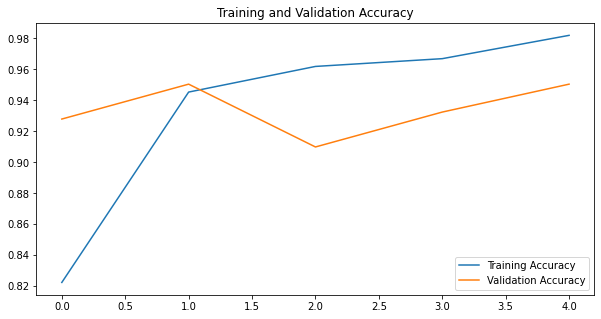

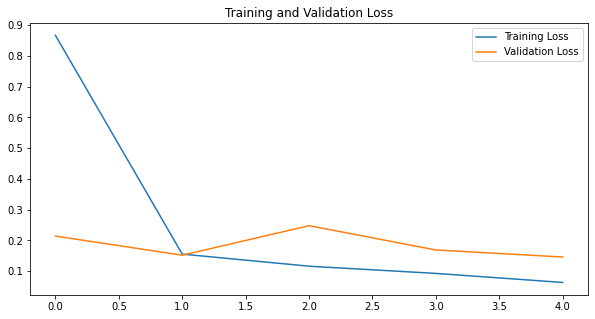

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(5)
plt.figure(figsize=(10,5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()
plt.figure(figsize=(10,5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
new_model = tf.keras.models.load_model('Solution/test_acc-95.h5')

Check model performance on test data

In [0]:
new_model.evaluate(X_test,y_test)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 248, 248, 64)      640       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 124, 124, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 122, 122, 64)      36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 61, 61, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 238144)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                15241280  
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

[0.07725270837545395, 0.9779179692268372]

In [0]:
yht = new_model.predict(X_train)

In [0]:
yht = yht.reshape(1,-1)[0].tolist()
y = y_train.reshape(1,-1)[0].tolist()

In [0]:
c = ['r' if(i==1) else 'g' for i in y]

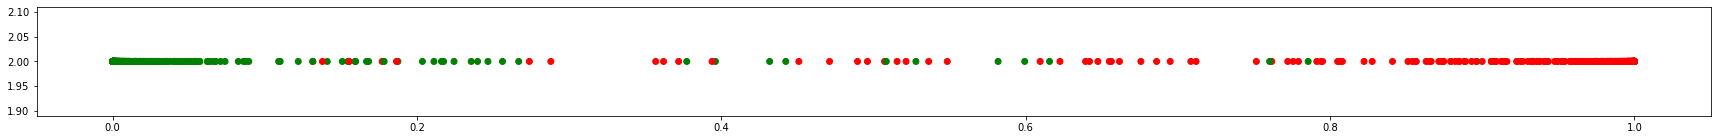

In [0]:
plt.figure(figsize=(0,2))
plt.scatter(yht,[2 for _ in range(len(yht))],c=c)
plt.show()

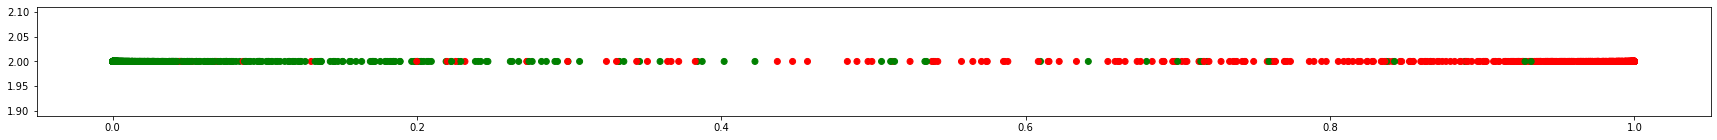

In [0]:
plt.figure(figsize=(30,2))
plt.scatter(yht,[2 for _ in range(len(yht))],c=c)
plt.show()

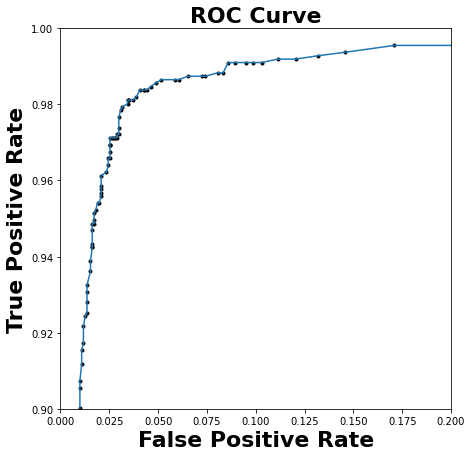

In [0]:
score = yht
fpr = []
# true positive rate
tpr = []
# Iterate thresholds from 0.0, 0.01, ... 1.0
thresholds = np.arange(0.0, 1.01, .01)

# get number of positive and negative examples in the dataset
P = sum(y)
N = len(y) - P

# iterate through all thresholds and determine fraction of true positives
# and false positives found at this threshold
for thresh in thresholds:
    FP=0
    TP=0
    for i in range(len(score)):
        if (score[i] > thresh):
            if y[i] == 1:
                TP = TP + 1
            if y[i] == 0:
                FP = FP + 1
    fpr.append(FP/float(N))
    tpr.append(TP/float(P))
plt.figure(figsize=(7,7))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.plot(fpr, tpr)
plt.scatter(fpr, tpr,c='k',marker='.')
plt.plot([0,1],[0,1], linestyle='dashed')
plt.xlabel('False Positive Rate',fontdict=font)
plt.ylabel('True Positive Rate',fontdict=font)
plt.title('ROC Curve',fontdict=font)
plt.ylim([0.9,1])
plt.xlim([0,0.2])
plt.show()

**One Hot Encoding the labeles**


In [0]:
ytemp = y_train.reshape(1,-1)[0].tolist()
yenc = tf.one_hot(ytemp,2)

In [0]:
model = Sequential()
model.add(Conv2D(64, (3,3), input_shape=(IMG_SIZE, IMG_SIZE,1),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='sigmoid'))
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

Create the base model from the pre-trained model **MobileNet V2**

In [0]:
history = model.fit(X_train,  yenc, epochs=5,validation_split=0.1)

Epoch 1/5
63/63 [==============================] - 46s 733ms/step - loss: 0.5918 - accuracy: 0.7523 - val_loss: 0.1932 - val_accuracy: 0.9369
Epoch 2/5
63/63 [==============================] - 47s 750ms/step - loss: 0.1912 - accuracy: 0.9263 - val_loss: 0.1411 - val_accuracy: 0.9505
Epoch 3/5
63/63 [==============================] - 48s 761ms/step - loss: 0.1330 - accuracy: 0.9483 - val_loss: 0.1584 - val_accuracy: 0.9414
Epoch 4/5
63/63 [==============================] - 46s 731ms/step - loss: 0.1194 - accuracy: 0.9544 - val_loss: 0.1669 - val_accuracy: 0.9279
Epoch 5/5
63/63 [==============================] - 47s 749ms/step - loss: 0.0648 - accuracy: 0.9764 - val_loss: 0.1820 - val_accuracy: 0.9324


(array([1111.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1105.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

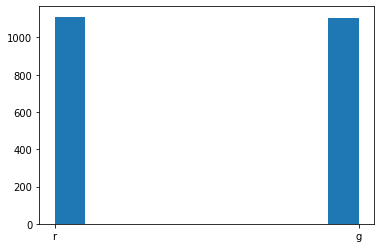

In [0]:
plt.hist(c)

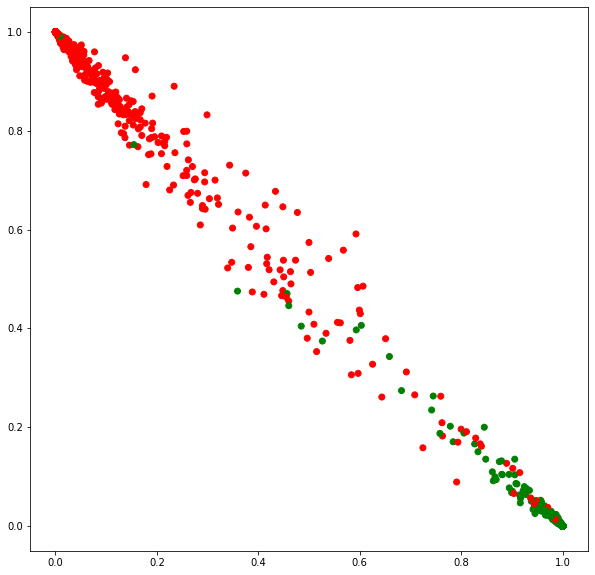

In [0]:
yht_enc = model.predict(X_train)
# c = ['r' if(i==1) else 'g' for i in y]
plt.figure(figsize=(10,10))
plt.scatter(yht_enc[:,0],yht_enc[:,1],c=c)
plt.show()